In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [4]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),   
     'act64': nn.ReLU(True), 
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
     'drop-64': nn.Dropout(.05),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),  
     'act192': nn.ReLU(True),   
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
     'drop-192': nn.Dropout(.1),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),    
     'act384': nn.ReLU(True),
     'drop-384': nn.Dropout(.15),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),     
     'act256a': nn.ReLU(True),
     'drop-256a': nn.Dropout(.1),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),     
     'act256b': nn.ReLU(True),   
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'drop-256b': nn.Dropout(.1),
     
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'drop-fc1': nn.Dropout(.05),
     
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'drop-fc2': nn.Dropout(.05),
     
     'out': nn.Linear(512, 10)})

In [5]:
criterion = TripletRegularizedMultiMarginLoss(0, .5, [])
sess = Session(model, criterion, optim.Adam, 1e-4)

In [6]:
num_epochs = 50
validator = EmbeddingSpaceValidator(valloader, select, CustomOneHotAccuracy, 
                                    model_file="./dropout.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*num_epochs, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [7]:
sess.train(schedule, num_epochs)

Validating: 100%|██████████| 157/157 [00:05<00:00, 30.44it/s]



val accuracy:  0.9735 
train loss:  0.0138  train BCE :  0.5 
valid loss:  0.0087  valid BCE :  0.2158


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.06it/s]



val accuracy:  0.9874 
train loss:  0.0071  train BCE :  0.1755 
valid loss:  0.0042  valid BCE :  0.1116


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.16it/s]



val accuracy:  0.9878 
train loss:  0.0054  train BCE :  0.1232 
valid loss:  0.0041  valid BCE :  0.0986


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.77it/s]



val accuracy:  0.9889 
train loss:  0.005  train BCE :  0.0972 
valid loss:  0.0035  valid BCE :  0.0824


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.05it/s]



val accuracy:  0.9899 
train loss:  0.0038  train BCE :  0.0824 
valid loss:  0.0032  valid BCE :  0.068


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.89it/s]



val accuracy:  0.9921 
train loss:  0.0029  train BCE :  0.0681 
valid loss:  0.0024  valid BCE :  0.0581


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.00it/s]



val accuracy:  0.9912 
train loss:  0.0023  train BCE :  0.0591 
valid loss:  0.0025  valid BCE :  0.0434


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.70it/s]



val accuracy:  0.9912 
train loss:  0.0025  train BCE :  0.0496 
valid loss:  0.0029  valid BCE :  0.0508


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.82it/s]



val accuracy:  0.9935 
train loss:  0.0027  train BCE :  0.0448 
valid loss:  0.0021  valid BCE :  0.0473


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.67it/s]



val accuracy:  0.9926 
train loss:  0.0014  train BCE :  0.0371 
valid loss:  0.0023  valid BCE :  0.0521


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.71it/s]



val accuracy:  0.9902 
train loss:  0.0015  train BCE :  0.0361 
valid loss:  0.0032  valid BCE :  0.0456


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.89it/s]



val accuracy:  0.9928 
train loss:  0.0014  train BCE :  0.0301 
valid loss:  0.0023  valid BCE :  0.041


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.73it/s]



val accuracy:  0.9928 
train loss:  0.0012  train BCE :  0.0268 
valid loss:  0.0023  valid BCE :  0.0312


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.01it/s]



val accuracy:  0.993 
train loss:  0.0011  train BCE :  0.026 
valid loss:  0.002  valid BCE :  0.0283


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.40it/s]



val accuracy:  0.9923 
train loss:  0.0011  train BCE :  0.0226 
valid loss:  0.0024  valid BCE :  0.0266


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.28it/s]



val accuracy:  0.9938 
train loss:  0.0011  train BCE :  0.0192 
valid loss:  0.0021  valid BCE :  0.0392


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.46it/s]



val accuracy:  0.9932 
train loss:  0.0015  train BCE :  0.0194 
valid loss:  0.0026  valid BCE :  0.0301


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.48it/s]



val accuracy:  0.9945 
train loss:  0.0005  train BCE :  0.0158 
valid loss:  0.0019  valid BCE :  0.0259


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.39it/s]



val accuracy:  0.994 
train loss:  0.0006  train BCE :  0.0144 
valid loss:  0.002  valid BCE :  0.0233


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.73it/s]



val accuracy:  0.9947 
train loss:  0.0003  train BCE :  0.016 
valid loss:  0.0016  valid BCE :  0.0213


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.34it/s]



val accuracy:  0.995 
train loss:  0.0008  train BCE :  0.0109 
valid loss:  0.0018  valid BCE :  0.0178


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.50it/s]



val accuracy:  0.9923 
train loss:  0.0003  train BCE :  0.01 
valid loss:  0.0028  valid BCE :  0.0282


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.24it/s]



val accuracy:  0.9941 
train loss:  0.0003  train BCE :  0.0109 
valid loss:  0.002  valid BCE :  0.0227


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.35it/s]



val accuracy:  0.9947 
train loss:  0.0005  train BCE :  0.0092 
valid loss:  0.0019  valid BCE :  0.0244


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.30it/s]



val accuracy:  0.9938 
train loss:  0.0003  train BCE :  0.0101 
valid loss:  0.002  valid BCE :  0.02


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.36it/s]



val accuracy:  0.9942 
train loss:  0.0001  train BCE :  0.0082 
valid loss:  0.0018  valid BCE :  0.0175


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.28it/s]



val accuracy:  0.9952 
train loss:  0.0003  train BCE :  0.0069 
valid loss:  0.0017  valid BCE :  0.0161


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.61it/s]



val accuracy:  0.995 
train loss:  0.0002  train BCE :  0.0075 
valid loss:  0.0017  valid BCE :  0.0167


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.36it/s]



val accuracy:  0.9951 
train loss:  0.0001  train BCE :  0.0049 
valid loss:  0.002  valid BCE :  0.0179


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.66it/s]



val accuracy:  0.9952 
train loss:  0.0001  train BCE :  0.0044 
valid loss:  0.0018  valid BCE :  0.0176


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.47it/s]



val accuracy:  0.9949 
train loss:  0.0  train BCE :  0.0047 
valid loss:  0.0019  valid BCE :  0.0159


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.28it/s]



val accuracy:  0.9935 
train loss:  0.0001  train BCE :  0.0041 
valid loss:  0.0024  valid BCE :  0.0202


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.46it/s]



val accuracy:  0.9942 
train loss:  0.0001  train BCE :  0.004 
valid loss:  0.002  valid BCE :  0.0169


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.50it/s]



val accuracy:  0.9944 
train loss:  0.0001  train BCE :  0.0033 
valid loss:  0.0022  valid BCE :  0.0179


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.56it/s]



val accuracy:  0.9951 
train loss:  0.0001  train BCE :  0.0031 
valid loss:  0.0018  valid BCE :  0.0148


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.47it/s]



val accuracy:  0.9949 
train loss:  0.0  train BCE :  0.0028 
valid loss:  0.002  valid BCE :  0.0159


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.55it/s]



val accuracy:  0.9945 
train loss:  0.0001  train BCE :  0.0021 
valid loss:  0.002  valid BCE :  0.0164


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.48it/s]



val accuracy:  0.9953 
train loss:  0.0  train BCE :  0.0023 
valid loss:  0.0018  valid BCE :  0.0159


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.36it/s]



val accuracy:  0.995 
train loss:  0.0  train BCE :  0.0023 
valid loss:  0.002  valid BCE :  0.0165


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.37it/s]



val accuracy:  0.9947 
train loss:  0.0001  train BCE :  0.0024 
valid loss:  0.002  valid BCE :  0.0159


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.51it/s]



val accuracy:  0.9956 
train loss:  0.0  train BCE :  0.0019 
valid loss:  0.0018  valid BCE :  0.0153


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.56it/s]



val accuracy:  0.9953 
train loss:  0.0  train BCE :  0.0017 
valid loss:  0.0019  valid BCE :  0.0156


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.44it/s]



val accuracy:  0.9956 
train loss:  0.0  train BCE :  0.0018 
valid loss:  0.0019  valid BCE :  0.015


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.40it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0015 
valid loss:  0.0019  valid BCE :  0.0152


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.69it/s]



val accuracy:  0.9955 
train loss:  0.0  train BCE :  0.0015 
valid loss:  0.0019  valid BCE :  0.0149


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.57it/s]



val accuracy:  0.9952 
train loss:  0.0  train BCE :  0.0014 
valid loss:  0.0019  valid BCE :  0.0151


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0014 
valid loss:  0.0019  valid BCE :  0.0151


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.42it/s]



val accuracy:  0.9949 
train loss:  0.0  train BCE :  0.0012 
valid loss:  0.0019  valid BCE :  0.0149


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.40it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0013 
valid loss:  0.0019  valid BCE :  0.0149


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.48it/s]



val accuracy:  0.9953 
train loss:  0.0  train BCE :  0.0013 
valid loss:  0.0019  valid BCE :  0.0149



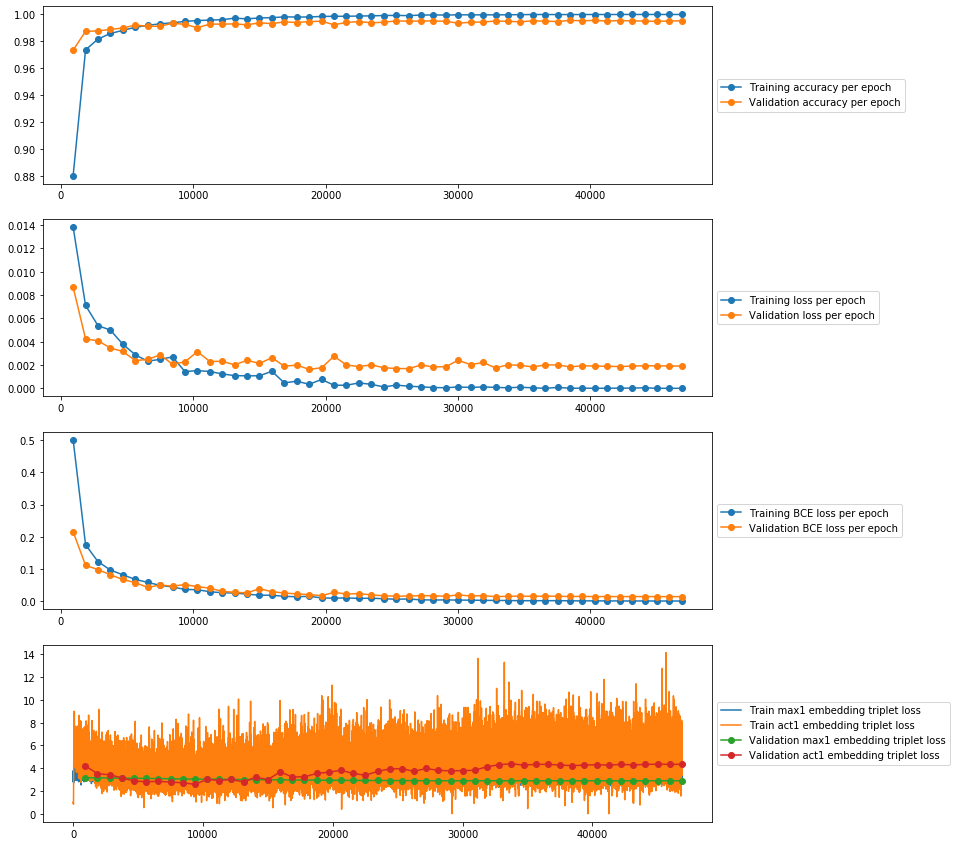

In [8]:
validator.plot()

In [9]:
sess.load("./dropout.ckpt.tar")

In [10]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, [], CustomOneHotAccuracy)

total_validator.run(sess)

Validating: 100%|██████████| 157/157 [00:04<00:00, 31.51it/s]


In [11]:
np.max(total_validator.val_accuracies), "Best accuracy with dropout"

(0.9953, 'Best accuracy with dropout')

In [12]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

tensorboard_embeddings(model, ['max1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')

tensorboard_embeddings(model, ['max2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')

tensorboard_embeddings(model, ['max3'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')

tensorboard_embeddings(model, ['act1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')

tensorboard_embeddings(model, ['act2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')

tensorboard_embeddings(model, ['out'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_dropout')